<a href="https://colab.research.google.com/github/tomonari-masada/course-nlp2020/blob/master/11_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 標準使用ライブラリー
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc
import os
import shutil
from icecream import ic
from tqdm import tqdm_notebook as tqdm 

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 追記
import json
import datetime
import math
plt.style.use('dark_background')

# debug
#%pdb on

import pixiedust #%pixie_debugger

# tfがエラーはかないため
# tfがエラーはかないため
#import tensorflow as tf
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="5"
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [4]:
import pandas as pd
import re
import emoji
from wordcloud import WordCloud, STOPWORDS

df = pd.read_csv("./result0605.csv", engine='python')

type(df["description"])
docs = df["description"].to_list()

In [5]:
print(len(docs))

93794


In [6]:
print(docs[0][:1000])

漫画、アニメ、声優垢。 RT多め気ままに呟きます。伏線系の漫画好き。古川慎さん・小林裕介さん・河西健吾さん ・田丸篤志さん推し


### Neologdを使ってtokenizeする

In [7]:
docs

['漫画、アニメ、声優垢。 RT多め気ままに呟きます。伏線系の漫画好き。古川慎さん・小林裕介さん・河西健吾さん ・田丸篤志さん推し',
 'D垢。プリンセスよく描いてけど…たまに違うものも描きます。手遅めですがよろしくお願いします🙇🙇 ※名前の読み方は自由なんで好きなように読んでください 最近は低浮上なので…別の絵垢 →@ri_ri_ri_ri_on',
 '𝖒𝖔𝖔𝖓𝖎𝖆𝖓 ♤  𝔣𝔱𝔦𝔰𝔩𝔞𝔫𝔡  ♢ 𝖒𝖎𝖞𝖆𝖛𝖎  ♧  𝔥𝔬𝔦𝔷𝔢𝔯  ♡  𝖇𝖇𝖟  ✩  𝔪𝔢𝔩𝔩𝔬𝔴𝔪𝔬𝔱𝔦𝔣\n˗ˏˋ⋆·˚ ༘ * アララカタブラツルリンコｫォォオ!!✩‧₊˚´ˎ˗.',
 'ENHYPEN、アニメ・漫画 ゲーム関連でTwitter使ってるので、それ以外は無反応です、、',
 '【心にゆとりと潤いを💞】目指すのは学校の保健室のような場所・ホッと一息つける場所｜あなたの幸せを願っています｜職業:音楽の講師｜《自分磨き中》自分らしくあるためのツイート｜思った事を呟きます｜時々ドジ有り｜🐶2匹と🐈4匹がいます🐾',
 '過去にジャパリカート動画、TSUMURI KART(VRChat)など作ったり、ワリスノ(MK8DX)一位だったりした人。\n社会に出てから疲れてる。\n配信→https://t.co/FJoitl8JHE\n\nヘッダの猫の飼い主→@___smmmmm',
 '🔥🎴・💎⚡️・⚡️🎴・👹🎴主の雑多垢🙏 成人20⬆️ic:自作 hd:@kmtmiu_ 様よりフリーヘッダー',
 '18↑ 夢追翔 伏見ガク ガオンくん応援アカウント アークナイツ dbdやってます',
 'スコティッシュ猫アンジェレッタ(2011,06,01生れの女の子）が可愛い過ぎて、毎日猫バカ生活です。\r\n好き☆猫☆動物☆爬虫類☆塊根植物☆藤原竜也☆ﾏﾝｶﾞ・ｱﾆﾒ☆大友克洋☆ＡＫＩＲＡ☆萩尾望都☆せがわまさき☆近藤片岡コンビ☆羽海野チカ☆ベルセルク☆ヒグチユウコ☆リラックマ☆沖縄☆',
 '98line/こもｻﾝ・堀ｻﾝ・健ｻﾝよりall▶LDHall love♡陸ｸﾝよりall↪︎#チームNEXT #ジェネ #ランペ #ファンタ  固定ツイrtいいねお願い ⚠※推し好きな物多め注意報⚠︎ /田中氏よりall▶ #スト #teamSixTONES ▶ #介護福祉',
 '21年毎日更新ブロ

In [8]:
import subprocess
cmd='echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
import MeCab
m=MeCab.Tagger("-Ochasen -d "+str(path_neologd))


def neolog_prep_text( text):
  return_words = []
  splited_text = (re.split('[\t,]', line) for line in m.parse(text).split('\n'))
  for tmp_word in splited_text :
    if (tmp_word[0] in ('EOS', '', 't', 'ー') ):
       continue 
    if not re.match( '名詞' ,tmp_word[3]  ) or tmp_word[0] in emoji.UNICODE_EMOJI["en"]:
      continue
    else:
      return_words.append(tmp_word[0])

  return return_words

* tokenizationの実行

In [11]:
from tqdm import tqdm

new_docs = list()
for doc in tqdm(docs):
  if str(doc) == "nan":
    continue
  tmp_words =  neolog_prep_text(str(doc))
  new_docs.append( tmp_words )
  

100%|██████████| 93794/93794 [00:23<00:00, 4048.87it/s]


* tokenizationの結果を確認

In [12]:
print(new_docs[5])

['過去', 'ジャパリカート', '動画', 'TSUMURI', 'KART', 'VRChat', 'ワリスノ', 'MK', '8', 'DX', '一位', 'りし', 'た人', '社会', '出て', '配信', 'https', 'co', 'FJoitl', '8', 'JHE', 'ヘッダ', '猫', '飼い主', 'smmmmm']


* 各文書を長い文字列で表しなおす（CountVectorizerを後で使うため）

In [13]:
corpus = [' '.join(doc) for doc in new_docs]

In [14]:
new_docs

[['漫画',
  'アニメ',
  '声優',
  '垢',
  'RT',
  '多め',
  '気まま',
  '伏線',
  '系',
  '漫画',
  '好き',
  '古川慎',
  'さん',
  '小林裕介',
  'さん',
  '河西健吾',
  'さん',
  '田丸篤志',
  'さん'],
 ['D',
  '垢',
  'プリンセス',
  'たま',
  'もの',
  '手遅',
  'め',
  'よろしくお願いします',
  '名前',
  '読み方',
  '自由',
  '好き',
  'よう',
  '最近',
  '浮上',
  '別',
  '絵',
  '垢',
  'ri',
  'ri',
  'ri',
  'ri',
  'on'],
 ['アララカタブラツルリンコｫォォオ', '₊'],
 ['ENHYPEN', 'アニメ', '漫画', 'ゲーム', '関連', 'Twitter', 'それ', '以外', '反応'],
 ['心',
  'ゆとり',
  '潤い',
  'の',
  '学校',
  '保健室',
  'よう',
  '場所',
  '一息',
  '場所',
  'あなた',
  '幸せ',
  '職業',
  '音楽',
  '講師',
  '自分磨き',
  '中',
  '自分',
  'ため',
  'ツイート',
  '事',
  'ドジ',
  '有り',
  '2',
  '匹',
  '4',
  '匹'],
 ['過去',
  'ジャパリカート',
  '動画',
  'TSUMURI',
  'KART',
  'VRChat',
  'ワリスノ',
  'MK',
  '8',
  'DX',
  '一位',
  'りし',
  'た人',
  '社会',
  '出て',
  '配信',
  'https',
  'co',
  'FJoitl',
  '8',
  'JHE',
  'ヘッダ',
  '猫',
  '飼い主',
  'smmmmm'],
 ['主', '雑多', '垢', '成人', '20', 'ic', '自作', 'hd', 'kmtmiu', '様', 'フリーヘッダー'],
 ['18', '夢追翔', '伏見', 'ガク', 'ガオン

## 11-02 データ行列の作成
* NMFの場合、TF-IDFで単語の重みを求めて各文書をベクトル化する。
* LDAの場合、単に単語の出現頻度を重みとして各文書をベクトル化する。

### sklearnのCountVectorizerで疎行列化する

* 全文書の半分より多い文書に現れる単語は、高頻度語とみなして削除する。
* 10件未満の文書にしか現れない単語は、低頻度語とみなして削除する。

In [18]:
import os
import urllib.request
def download_stopwords(path):
    url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
    if os.path.exists(path):
        print('File already exists.')
    else:
        print('Downloading...')
        # Download the file from `url` and save it locally under `file_name`:
        urllib.request.urlretrieve(url, path)

def create_stopwords(file_path):
    stop_words = []
    for w in open(path, "r"):
        w = w.replace('\n','')
        if len(w) > 0:
          stop_words.append(w)
    return stop_words    

path = "stop_words.txt"
download_stopwords(path)
stop_words = create_stopwords(path)

File already exists.


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.5, min_df=10, stop_words=stop_words)
X = vectorizer.fit_transform(corpus)

In [23]:
print(vectorizer.get_feature_names())

['00', '000', '001', '007', '009', '01', '0101', '011', '0120', '0129', '016', '02', '020', '021', '0221', '03', '04', '05', '0501', '06', '0626', '07', '08', '09', '090', '092', '0g', '0m', '0t', '0v', '0w', '0時', '0歳', '10', '100', '1000', '10000', '1000万', '1000人', '100パーセント', '100万', '100万円', '100人', '100円', '100均', '100年', '100本', '101', '1010', '1013', '1014', '1016', '1026', '104', '105', '106', '107', '108', '109', '10t', '10万', '10万円', '10代', '10分', '10周年', '10回', '10年', '10年目', '10時', '10月', '10歳', '11', '110', '1100', '1102', '1106', '1111', '1115', '112', '1120', '1123', '1127', '113', '114', '114514', '115', '119', '11回', '11年', '11年目', '11時', '11月', '11歳', '12', '120', '1200', '1203', '1205', '1208', '1220', '1224', '1226', '123', '1234', '124', '125', '127', '129', '12年', '12年目', '12時', '12月', '12歳', '13', '130', '1300', '139', '13年', '13年目', '13時', '13歳', '14', '140', '147', '148', '14年', '14年目', '14歳', '15', '150', '1500', '151', '157', '15年', '15年目', '15時', '15歳', '16

In [24]:
print(len(vectorizer.get_feature_names()))

13363


* 文書数と語彙サイズを変数にセット

In [26]:
n_samples, n_features = X.shape

### TF-IDFで各文書における単語の重みを計算する

In [27]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
Xtfidf = tfidf.fit_transform(X)

In [28]:
print(Xtfidf[0])

  (0, 11047)	0.431803321010621
  (0, 10837)	0.33656875348588305
  (0, 9484)	0.5130933332785758
  (0, 9223)	0.13211295128074138
  (0, 9017)	0.23896590223193948
  (0, 8983)	0.25614707531784403
  (0, 8682)	0.4747756969099675
  (0, 4664)	0.1719552270462194
  (0, 2706)	0.20457804496538182


In [29]:
Xtfidf.shape

(88481, 13363)

* 抽出するトピックの個数は、今回は20個とする。

In [30]:
n_components = 6

## 11-03 NMFでトピック抽出
* まず、TF-IDFのデータ行列を使って　NMFによってトピック抽出を試みる。
 * NMFのパラメータ群は下記サンプルコードのまま。
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

### NMFとLDAのインポート

In [31]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

### NMFによるトピック抽出の実行

In [32]:
from time import time

print((f"Fitting the NMF model (generalized Kullback-Leibler "
  f"divergence) with tf-idf features, n_samples={n_samples} "
  f"and n_features={n_features}"))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5,
          verbose=1)
nmf.fit(Xtfidf)
print(f"done in {time() - t0:0.3f}s.")

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=88481 and n_features=13363
Epoch 10 reached after 2.648 seconds, error: 1680.460155
Epoch 20 reached after 5.148 seconds, error: 1678.500589
Epoch 30 reached after 7.548 seconds, error: 1677.944987
Epoch 40 reached after 10.010 seconds, error: 1677.667771
Epoch 50 reached after 12.459 seconds, error: 1677.508079
done in 13.498s.


* NMFにおける各コンポーネントは、それぞれのトピックにおける単語の重要度を表すベクトルとして表現されている。

In [33]:
nmf.components_

array([[1.65148109e-02, 1.34028697e-02, 1.50681959e-03, ...,
        1.36298496e-03, 6.17774559e-04, 3.22931643e-04],
       [1.53018381e-01, 1.09810397e-02, 3.48289873e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.65940353e-06, 4.39714718e-03, 2.77157228e-03, ...,
        5.79604807e-03, 0.00000000e+00, 0.00000000e+00],
       [4.04683138e-03, 8.80197630e-13, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.10509570e-03, 1.01485043e-06, 0.00000000e+00, ...,
        1.51627896e-03, 1.04033918e-02, 4.30708642e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.18941484e-03, 0.00000000e+00, 0.00000000e+00]])

### トピックの重要語を取り出す関数の定義

In [34]:
def get_top_words(model, feature_names, n_top_words=30):
  top_features = list()
  weights = list()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features.append([feature_names[i] for i in top_features_ind])
    weights.append(topic[top_features_ind])
  return top_features, weights

### NMFの各コンポーネントから重要語を取り出す

In [35]:
top_words, weights = get_top_words(nmf, vectorizer.get_feature_names())

In [38]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

In [39]:
topic_words[0]

{'好き': 2.3530810259394888,
 '映画': 0.437770478523959,
 'アニメ': 0.39129547934183295,
 '趣味': 0.3635496891437839,
 '音楽': 0.3436840750778855,
 '写真': 0.3209291391161282,
 '最近': 0.29745299067498737,
 '人生': 0.28070045477434014,
 '仕事': 0.26173127962254944,
 '漫画': 0.2319059565352211,
 'ゲーム': 0.21621678484730217,
 '日々': 0.20258337610092558,
 'ツイート': 0.19043432114481745,
 '動物': 0.17355649262289258,
 '現在': 0.17230060007716932,
 '気軽': 0.15472435680366148,
 'ブログ': 0.15166155942426576,
 'アカウント': 0.15155873793212782,
 'フォロー': 0.15128240617085764,
 '料理': 0.1486482889512818,
 '読書': 0.14838591523166234,
 'たま': 0.14791047296330145,
 '特撮': 0.14660863856656892,
 '在住': 0.14483202015118105,
 '勉強': 0.1392014097495919,
 '基本': 0.13906268142671002,
 '興味': 0.13899286829486557,
 'バイク': 0.13210520880842722,
 'おじさん': 0.13127152413387025,
 '世界': 0.12616620587432711}

### 重要語をワードクラウドで可視化

In [40]:
from matplotlib import pyplot as plt

* ワードクラウドから除去するストップワードを確認する。

* ワードクラウドを描画

In [42]:
FONT_PATH = "/usr/share/fonts/opentype/ipaexfont-mincho/ipaexm.ttf"
cloud = WordCloud(stopwords=STOPWORDS,
                  font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

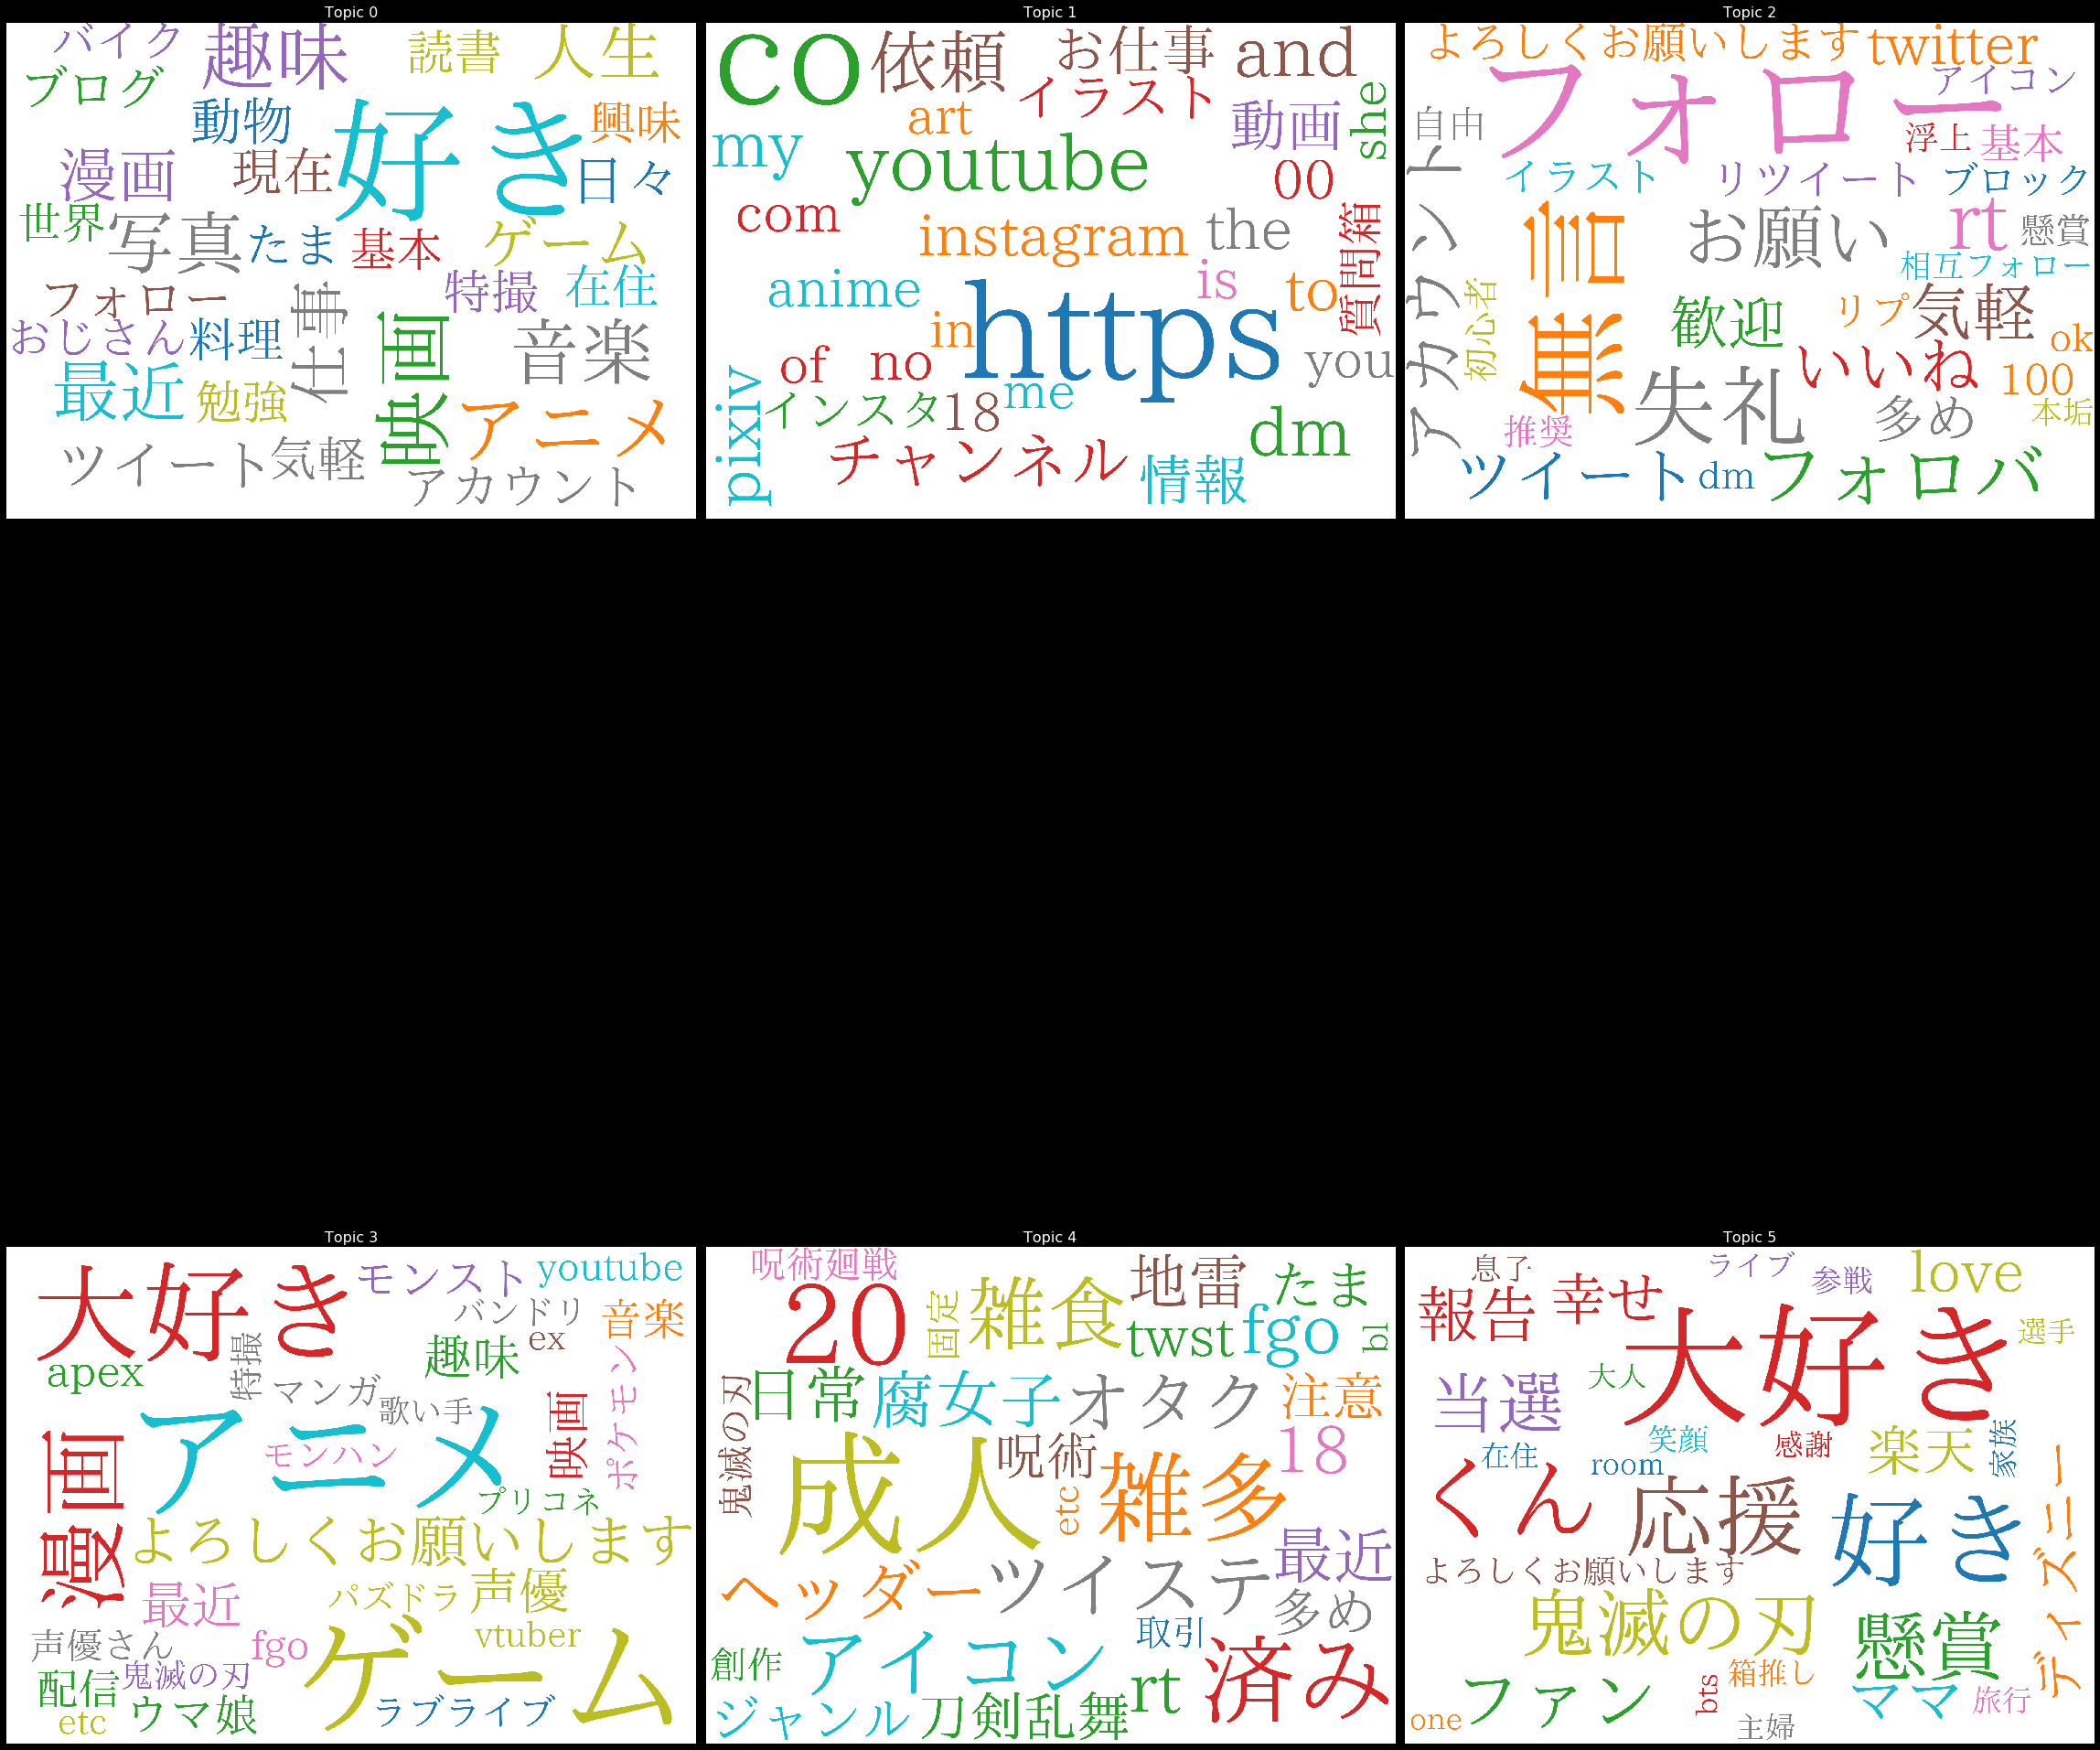

In [43]:
# fig, axes = plt.subplots(10, 2, figsize=(32, 50), sharex=True, sharey=True)
tate = math.ceil(n_components / 3)
fig, axes = plt.subplots(tate, 3, figsize=(32, 50), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    
  if i > len(topic_words)-1:
    break
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

## 11-04 LDAでトピック抽出

### LDAによるトピック抽出の実行

In [44]:
lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=20,
                                topic_word_prior=0.01,
                                learning_method='online',
                                learning_offset=50,
                                batch_size=200,
                                mean_change_tol=1e-4,
                                random_state=1,
                                evaluate_every=1,
                                verbose=1)

In [45]:
print((f"Fitting LDA models with tf features, "
  f"n_samples={n_samples} and n_features={n_features}"))
t0 = time()
lda.fit(X)
print(f"done in {time() - t0:0.3f}s.")

Fitting LDA models with tf features, n_samples=88481 and n_features=13363
iteration: 1 of max_iter: 20, perplexity: 6692.4215
iteration: 2 of max_iter: 20, perplexity: 6512.5604
iteration: 3 of max_iter: 20, perplexity: 6460.0357
iteration: 4 of max_iter: 20, perplexity: 6436.6653
iteration: 5 of max_iter: 20, perplexity: 6422.9770
iteration: 6 of max_iter: 20, perplexity: 6414.6399
iteration: 7 of max_iter: 20, perplexity: 6408.9167
iteration: 8 of max_iter: 20, perplexity: 6404.9163
iteration: 9 of max_iter: 20, perplexity: 6401.9039
iteration: 10 of max_iter: 20, perplexity: 6399.5434
iteration: 11 of max_iter: 20, perplexity: 6397.6518
iteration: 12 of max_iter: 20, perplexity: 6396.0082
iteration: 13 of max_iter: 20, perplexity: 6394.6726
iteration: 14 of max_iter: 20, perplexity: 6393.5925
iteration: 15 of max_iter: 20, perplexity: 6392.6700
iteration: 16 of max_iter: 20, perplexity: 6391.9034
iteration: 17 of max_iter: 20, perplexity: 6391.2610
iteration: 18 of max_iter: 20, per

### LDAの各トピックから高確率語を取り出す

In [46]:
top_words, weights = get_top_words(lda, vectorizer.get_feature_names())

In [47]:
print(top_words[0])

['好き', 'アニメ', '大好き', 'ゲーム', '漫画', '趣味', '映画', '最近', '音楽', '声優', '懸賞', 'よろしくお願いします', 'fgo', '仕事', '特撮', '当選', '鬼滅の刃', 'etc', 'オタク', 'ポケモン', 'ウマ娘', '報告', 'マンガ', 'モンスト', '旅行', '料理', 'lisa', '社会人', '声優さん', '動物']


In [48]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

### 高確率語をワードクラウドで可視化

In [54]:
cloud = WordCloud(stopwords=STOPWORDS,
                                font_path=FONT_PATH,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

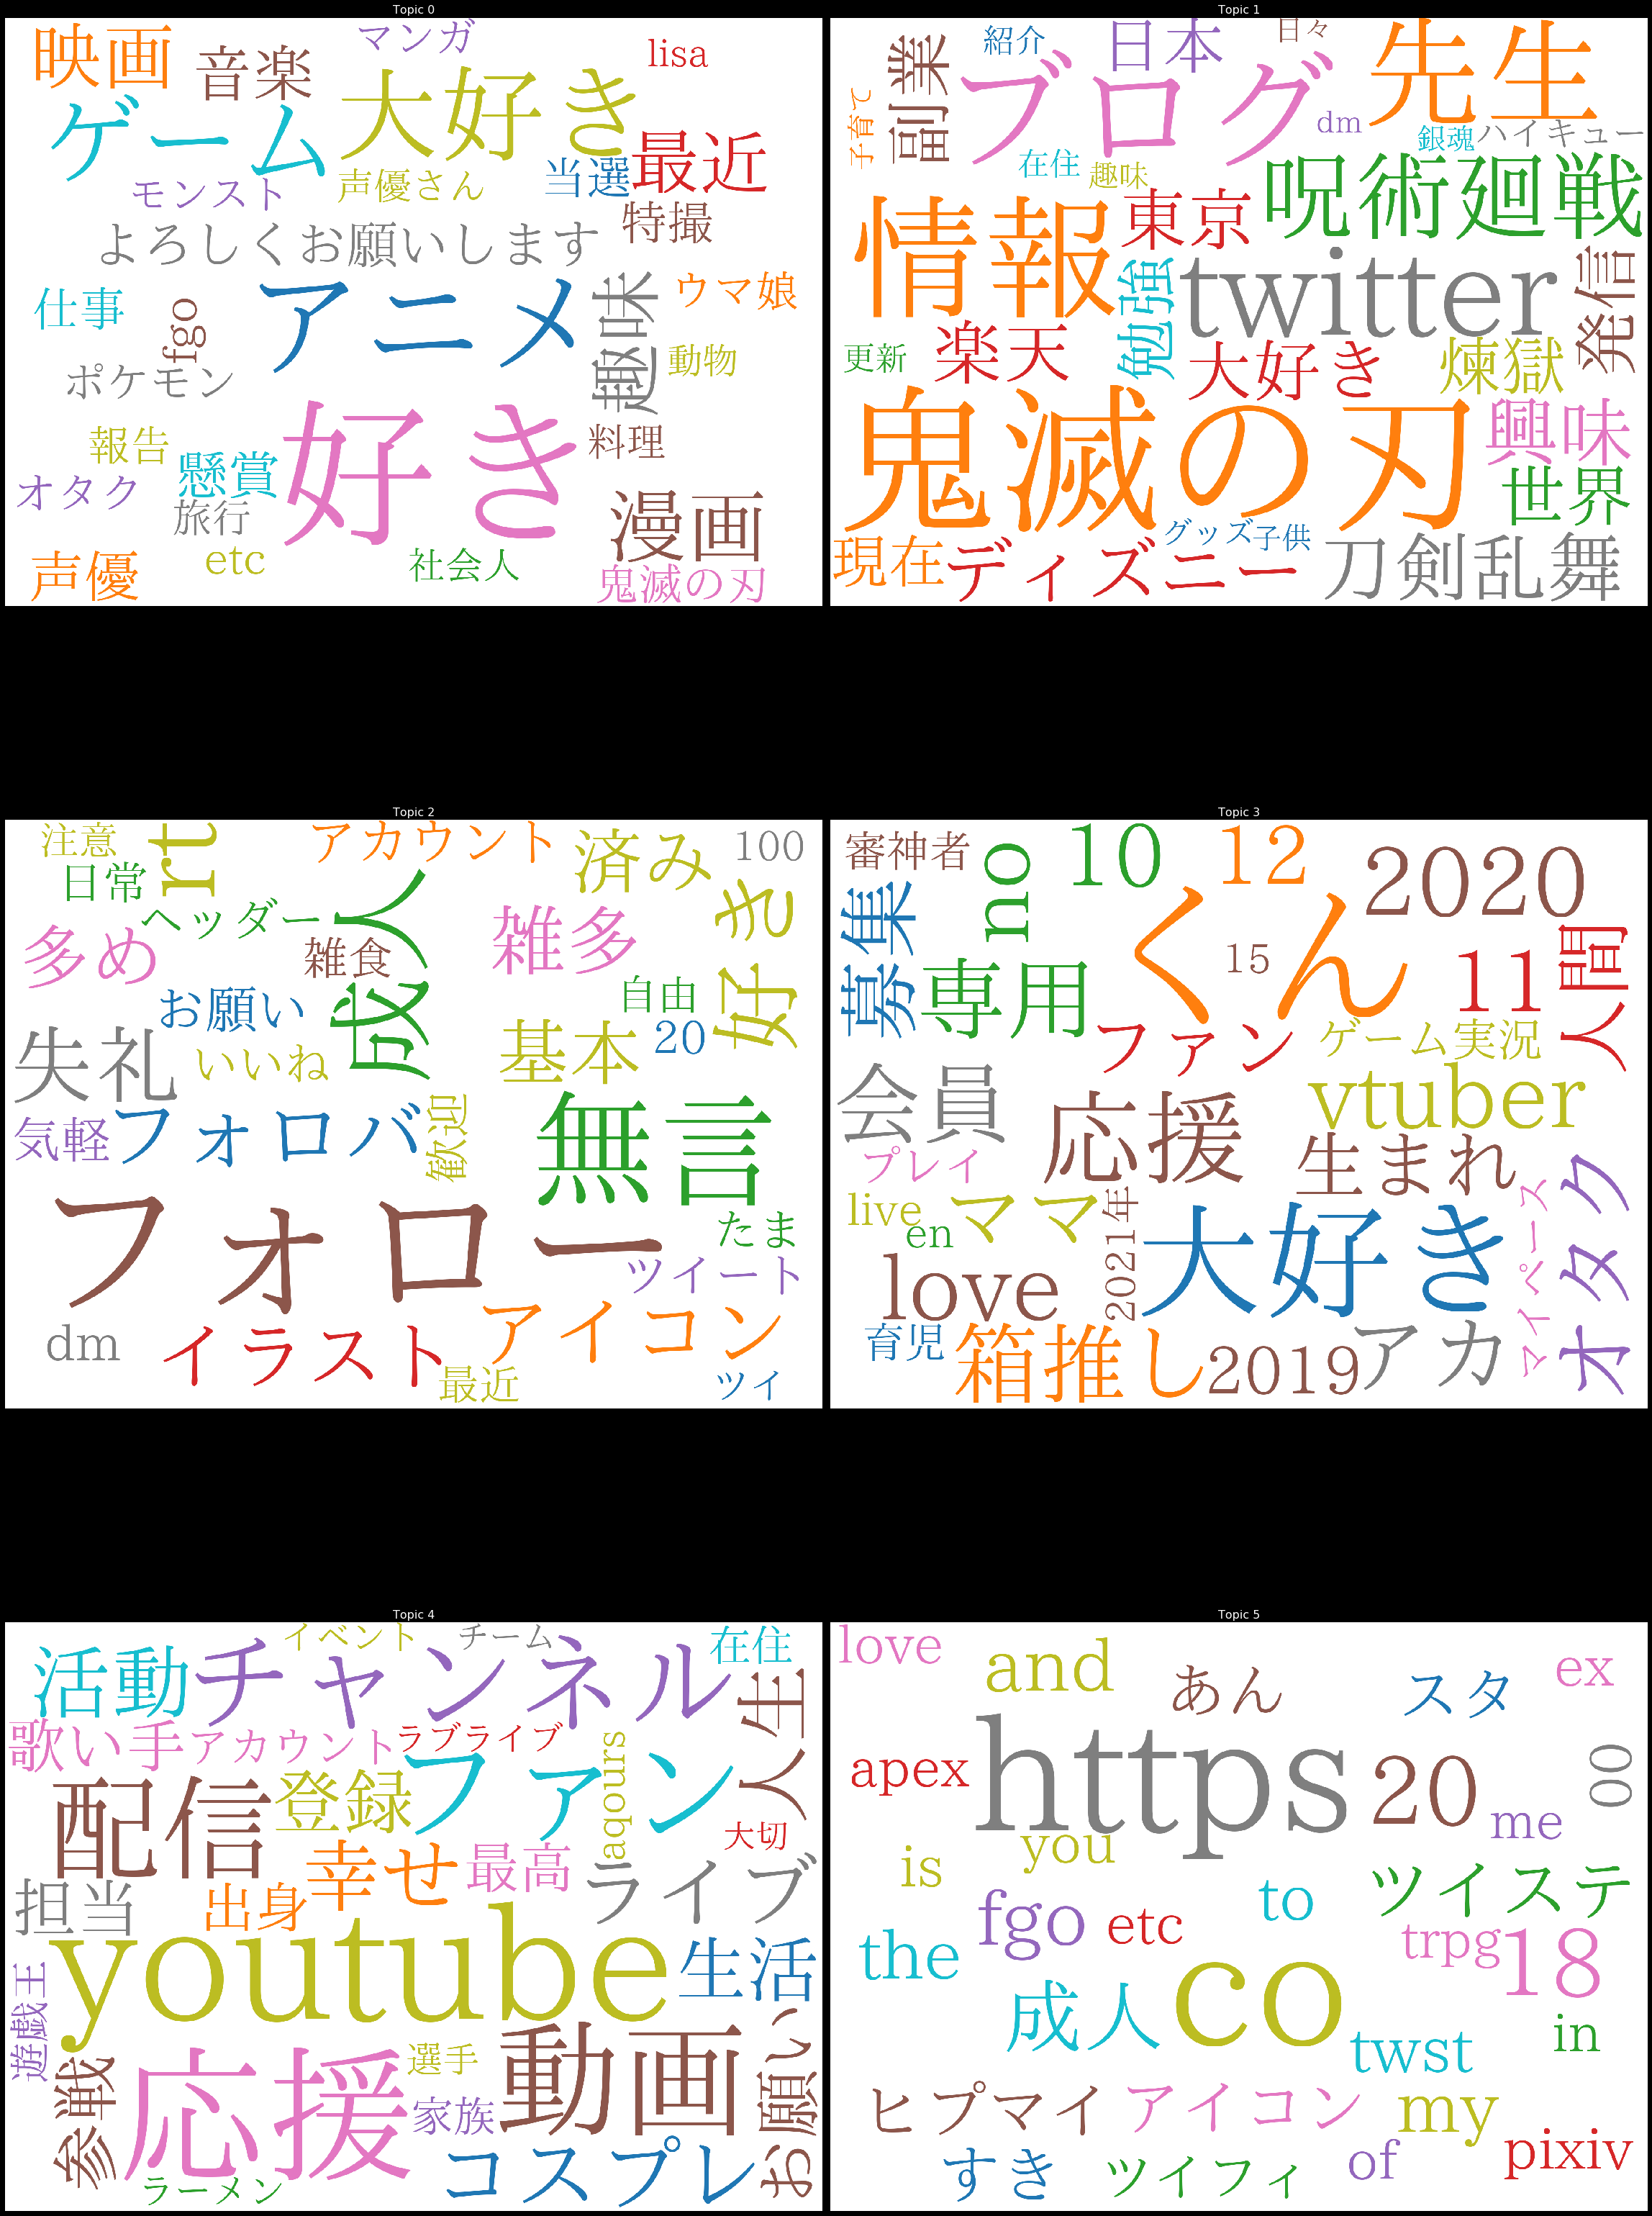

In [55]:
# fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)
tate = math.ceil(n_components / 2)
fig, axes = plt.subplots(tate, 2, figsize=(32, 50), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    
  if i > len(topic_words)-1:
    break

  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=500)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()


from matplotlib.backends.backend_pdf import PdfPages

import datetime
pdf = PdfPages( 
(datetime.datetime.now() + datetime.timedelta(hours=9) ) .strftime('%m%d_%H%M') + 'topic.pdf')


fignums = plt.get_fignums()
for fignum in fignums:
    plt.figure(fignum)
    pdf.savefig()

pdf.close()

In [52]:
import pyLDAvis
import pyLDAvis.sklearn

In [53]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2       1.465019 -47.625065       1        1  23.803202
0      54.854797 -36.476795       2        1  22.710899
5      32.212929 -61.444572       3        1  14.293022
1       5.111096 -14.110332       4        1  14.135027
4      26.350170 -33.374702       5        1  13.299886
3      38.109818  -7.222781       6        1  11.757964, topic_info=       Term          Freq         Total Category  logprob  loglift
9223     好き  25650.000000  25650.000000  Default  30.0000  30.0000
1082     co  10866.000000  10866.000000  Default  29.0000  29.0000
1722  https  10654.000000  10654.000000  Default  28.0000  28.0000
6587   フォロー  14379.000000  14379.000000  Default  27.0000  27.0000
4664    アニメ  10008.000000  10008.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
7933     人間    593.088847    870.327390   Topic6  -5.2564   1.7571
9849     応援   1061.495369   2823.562096   Topic6  -4.6743   1.1623
9090    大好き   1797.314809  11445.388558   Topic6  -4.1477   0.2893
4941    オタク    765.033236   1940.605058   Topic6  -5.0019   1.2098
6547    ファン    552.896204   1881.784469   Topic6  -5.3266   0.9158

[303 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
0          3  1.000423    00
5          5  1.000161    01
33         5  0.251457    10
33         6  0.748953    10
34         1  0.944426   100
...      ...       ...   ...
12986      5  0.133857    音楽
13128      1  0.057211  鬼滅の刃
13128      2  0.362334  鬼滅の刃
13128      4  0.580411  鬼滅の刃
13173      5  0.997973    麻雀

[368 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 6, 2, 5, 4])